## Distance Matrix Calculation
### Objetive: Given a Shapefile with Form and Subsections, generate a Distance Matrix 

In [1]:
# list of imports
import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from multiprocessing import Pool
from functools import partial
import numpy as np
from shapely.geometry import Point

In [2]:
# Load Necessary Data

# Load data Polygons 
polygons = gpd.read_file('./data/BGRI_2011/CONTINENTE/BGRI11_CONT.shp', dtype={'BGRI11': str})

# Add a column with all centroids
# polygons = polygons.to_crs({'init': 'epsg:4326'})
# polygons['sCentroid'] = polygons.centroid

In [28]:
# Load School Data
schools = gpd.read_file('../optimization/data_gettin/escolasourem/gdf_escolas_Ourem2019_capacidades.shp')

In [29]:
schools.index = schools.Nome_Escol
schools = schools.to_crs({'init': 'epsg:4326'})

In [7]:
def select_shape(column, value, polygons):
    # Load BGRI-2011 Data
    polygons = polygons[polygons[column]==value]
    shape_df = polygons.dissolve(by=column, as_index=False)
    return shape_df

In [8]:
def get_network(shape_dataFrame):
    latlng_geom, _ = ox.project_geometry(shape_dataFrame.geometry[0], crs={'init':'epsg:3763'}, to_latlong=True)
    network = ox.graph_from_polygon(latlng_geom, network_type='all_private')
    return network

In [9]:
def calculate_distance(point1, point2):

    node1 = ox.utils.get_nearest_node(myNetwork, (point1.y, point1.x))
    node2 = ox.utils.get_nearest_node(myNetwork, (point2.y, point2.x))
    try:
        distance = nx.shortest_path_length(myNetwork, node1, node2, weight='length')
    except Exception as ex:
        print('Node {} not reachable from {}'.format(point1, point2))
        print(ex)
        distance = float('NaN')
    return distance

In [10]:
def parallelize(data, func, num_of_processes=7):
#     data_split = np.array_split(data, num_of_processes)
    pool = Pool(num_of_processes)
    # This will concat the operation with the iterable itens from data_split
    listOfBgri = list(data[['from', 'to']].itertuples(index=True, name=None))
    data_split = np.array_split(listOfBgri, num_of_processes)
#     data = pd.concat(pool.map(func, data_split))
#     print(data_split[0])
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)

def parallelize_on_rows(data, func, num_of_processes=7):
    return parallelize(data, partial(run_calculation, func), num_of_processes)

def run_calculation(func, points):
    index = []
    values = []
 
    for e in points:
        index.append(int(e[0]))
        values.append(calculate_distance(bgri.loc[e[1]].geometry, bgri.loc[e[2]].geometry))
    partialDistances = pd.Series(values, index=index) 
    return partialDistances

In [11]:
def create_distance_matrix(bgri_df):
    pairwise = pd.DataFrame(columns = bgri_df.index, index = bgri_df.index)
    long_form = pairwise.unstack()
    long_form.index.rename(['from', 'to'], inplace=True)
    long_form = long_form.to_frame('real_distance').reset_index()
    # ---- Multiprocess ----
    long_form['real_distance'] = parallelize_on_rows(long_form, calculate_distance)
    return long_form

In [12]:
def create_distance_matrix_to_sig(bgri_df, sig_gdf):
    pairwise = pd.DataFrame(columns = schools.index, index = bgri_df.index)
    long_form = pairwise.unstack()
    long_form.index.rename(['from', 'to'], inplace=True)
    long_form = long_form.to_frame('real_distance').reset_index()
    # ---- Multiprocess ----
    long_form['real_distance'] = parallelize_on_rows(long_form, calculate_distance)
    return long_form

In [11]:
# List of Globals

# BGRI for the selected Place
bgri = polygons[polygons['DTMN11']=='0903'].to_crs({'init': 'epsg:4326'})
bgri['geometry'] = bgri.centroid
bgri.index = bgri.BGRI11

In [14]:
shape_df = select_shape('DTMN11', '1421', polygons)

In [15]:
myNetwork = get_network(shape_df)

In [14]:
shape_df = shape_df.to_crs({'init': 'epsg:4326'})

In [15]:
# points = bgri.loc[['09031600206', '09031600201']]
# base = bgri.plot()
# points.plot(ax=base, marker='o', color='red', markersize=5);

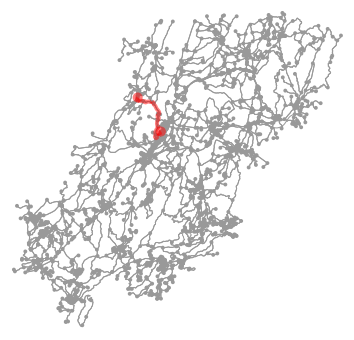

(<Figure size 593.796x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f662d2b5c88>)

In [16]:
node1 = ox.utils.get_nearest_node(myNetwork, (bgri.loc['09031600201'].geometry.y, bgri.loc['09031600201'].geometry.x), method='euclidean')

node2 = ox.utils.get_nearest_node(myNetwork, (bgri.loc['09031600206'].geometry.y, bgri.loc['09031600206'].geometry.x), method='euclidean')

route = nx.shortest_path(myNetwork, node1, node2)
ox.plot_graph_route(myNetwork, route)

In [17]:
# points = bgri.loc[['09031700111', '09030700125']]
# base = polygons[polygons['DTMN11']=='0903'].to_crs({'init': 'epsg:4326'}).plot()
# points.plot(ax=base, marker='o', color='red', markersize=5);

In [18]:
# node1 = ox.utils.get_nearest_node(myNetwork, (bgri.loc['09031700111'].geometry.y, bgri.loc['09031700111'].geometry.x))

# node2 = ox.utils.get_nearest_node(myNetwork, (bgri.loc['09030700125'].geometry.y, bgri.loc['09030700125'].geometry.x))

# route = nx.shortest_path(myNetwork, node1, node2)
# ox.plot_graph_route(myNetwork, route)

In [19]:
result = create_distance_matrix(bgri.head(100))

In [20]:
point1 = Point(-7.313499936901444, 40.64471169382188)
point2 = Point(-7.411244264833021, 40.65630294536609)
calculate_distance(point1,point2)

Node POINT (-7.313499936901444 40.64471169382188) not reachable from POINT (-7.411244264833021 40.65630294536609)
Node 1599277062 not reachable from 264360157


nan

In [5]:
polygons.centroid

0          POINT (70250.774 187367.022)
1          POINT (70289.266 187137.974)
2          POINT (67325.763 188069.355)
3          POINT (67586.273 188073.091)
4          POINT (71555.623 205480.006)
                      ...              
255839     POINT (-15270.344 97095.131)
255840     POINT (-15673.692 97209.760)
255841    POINT (-16108.927 100849.486)
255842     POINT (-16230.798 97886.264)
255843     POINT (-15955.290 98183.825)
Length: 255844, dtype: geometry

In [30]:
bgri = polygons[polygons['DTMN11']=='1421'].to_crs({'init': 'epsg:4326'})
bgri.geometry = bgri.centroid
point1 = Point(schools.iloc[0].geometry.x, schools.iloc[0].geometry.y)
point2 = Point(bgri.iloc[0].geometry.x, bgri.iloc[0].geometry.y)
calculate_distance(point1,point2)

19644.463999999985

In [34]:
point1.xy

(array('d', [-8.529436413957008]), array('d', [39.706034739201485]))

In [35]:
point1.xy

(array('d', [-8.681414629433988]), array('d', [39.637320983562695]))

In [21]:
result.to_csv('./data/distancematrix-0903.csv')


In [22]:
bgri = polygons[polygons['DTMN11']=='1421'].to_crs({'init': 'epsg:4326'})
bgri['geometry'] = bgri.centroid
bgri.index = bgri.BGRI11
result = create_distance_matrix_to_sig(bgri, schools)

KeyError: '1  EB da Cova da Iria (JI/EB1)'